从零开始实现整个线性回归,包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [1]:
from pickle import TRUE
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集.使用线性模型参数$w=[2,-3.4]^T$、b=4.2和噪声项c生成数据集及其标签$y = Xw + b + c$

In [2]:
def synthetic_data(w, b, num_examples):
    """
    生成噪声：y = Xw + b + 噪声
    """
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1,1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b,1000)

feature每行都包含一个二维数据样本,labels中每一行都包含一维标签值(一个标量)

In [3]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([1.7181, 0.1918]) 
label: tensor([6.9672])


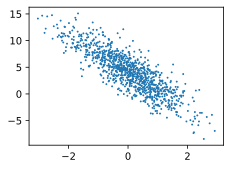

In [4]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),
                labels.detach().numpy(), 1)

定义一个data_iter函数,该函数接受批量大小,特征矩阵和标签向量作为输入,生成大小为batch_size的小批量

In [5]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-0.6425,  1.3567],
        [ 0.0056,  0.5326],
        [ 0.1090,  0.0569],
        [-0.5501, -0.4782],
        [-0.8145,  0.7517],
        [-1.4334, -0.8362],
        [ 0.6643,  1.7915],
        [-0.3642,  0.7821],
        [ 0.7186,  0.2670],
        [ 0.6022, -0.4710]]) 
 tensor([[-1.7148],
        [ 2.3995],
        [ 4.2200],
        [ 4.7252],
        [ 0.0075],
        [ 4.1754],
        [-0.5418],
        [ 0.8197],
        [ 4.7118],
        [ 6.9982]])


定义 初始化模型参数

In [6]:
w = torch.normal(0, 0.01, size=(2,1),requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型

In [7]:
def linreg(X, w, b):
    # 线性回归模型
    return torch.matmul(X, w) + b

定义损失函数

In [8]:
def squared_loss(y_hat, y):
    # 均方损失
    return (y_hat - y.reshape(y_hat.shape))**2/2

定义优化算法

In [9]:
def sgd(params, lr, batch_size):
    # 小批量随机梯度下降
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练过程

In [10]:
lr = 0.03 #学习率
num_epochs = 3 # 数据过三次
net = linreg # 方便换模型
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y) # X和y的小批量损失
        # l形状是 （batch_size），不是标量，所以l中元素被加到一起
        # 以此计算wb的梯度
        l.sum().backward()
        sgd([w, b], lr,batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b),labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.041678
epoch 2, loss 0.000157
epoch 3, loss 0.000049


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [11]:
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([ 0.0003, -0.0003], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0003], grad_fn=<RsubBackward1>)
